# Blindness Detection

In [1]:
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator
from efficientnet.keras import EfficientNetB5
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os

In [2]:
path = "C:\\Users\\prabh\\OneDrive\\Desktop\\Projects\\AI - Blindness Detection\\"

In [3]:
df = pd.read_csv(path + "train.csv")

df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


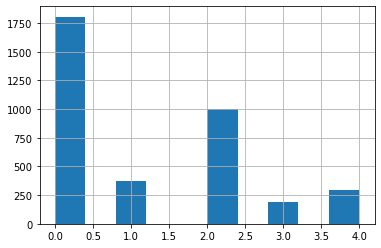

In [4]:
df["diagnosis"].hist();

In [5]:
df["diagnosis"].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

## Training Image

In [6]:
files = os.listdir(path + "train_images")

In [7]:
img_list = []

for i in files[0:20]:
    image = cv2.imread(path + "train_images\\" + i)
    image = cv2.resize(src=image, dsize=(400,400))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_list.append(image)
    
len(img_list)

20

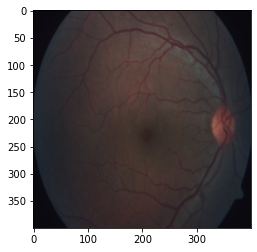

In [8]:
plt.imshow(img_list[6]);

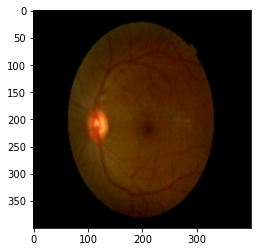

In [9]:
plt.imshow(img_list[4]);

In [10]:
img_list[4].shape

(400, 400, 3)

## Morphological Operations
1- Threshold (works with GRAY Images)

2- Gaussian Blur

3- Find Contour

4- Get Coordinates

5- Crop Images

6- Resize Images

(400, 400)

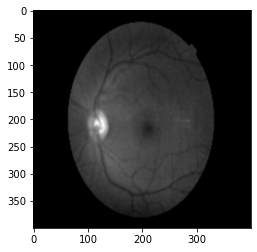

In [11]:
img = cv2.cvtColor(img_list[4].copy(), cv2.COLOR_RGB2GRAY)
plt.imshow(img, cmap='gray');
img.shape

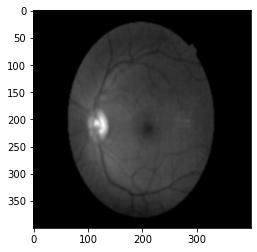

In [12]:
blur = cv2.GaussianBlur(src=img, ksize=(5,5), sigmaX=0)
plt.imshow(blur, cmap='gray');

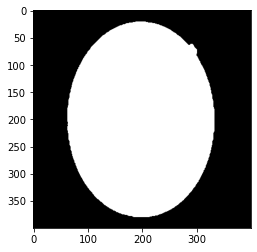

In [13]:
thres = cv2.threshold(blur,10 ,255, cv2.THRESH_BINARY)[1]
plt.imshow(thres, cmap='gray');

In [14]:
contour = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0]

In [15]:
contour.shape

(440, 1, 2)

In [16]:
contour = contour[:,0,:]
contour.shape

(440, 2)

In [17]:
contour

array([[188,  21],
       [187,  22],
       [183,  22],
       [182,  23],
       [176,  23],
       [175,  24],
       [171,  24],
       [170,  25],
       [169,  25],
       [168,  26],
       [165,  26],
       [164,  27],
       [163,  27],
       [162,  28],
       [159,  28],
       [158,  29],
       [157,  29],
       [156,  30],
       [155,  30],
       [154,  31],
       [153,  31],
       [152,  32],
       [151,  32],
       [150,  33],
       [149,  33],
       [148,  34],
       [147,  34],
       [146,  35],
       [145,  35],
       [144,  36],
       [143,  36],
       [142,  37],
       [141,  37],
       [138,  40],
       [137,  40],
       [136,  41],
       [135,  41],
       [131,  45],
       [130,  45],
       [129,  46],
       [128,  46],
       [106,  68],
       [106,  69],
       [105,  70],
       [105,  71],
       [100,  76],
       [100,  77],
       [ 99,  78],
       [ 99,  79],
       [ 96,  82],
       [ 96,  83],
       [ 94,  85],
       [ 94,

In [18]:
contour[:,0].argmax()

327

In [19]:
contour[335]

array([328, 162], dtype=int32)

In [20]:
contour[:,0].argmin() 

105

In [21]:
contour[111] 

array([ 64, 212], dtype=int32)

In [22]:
left = tuple(contour[contour[:,0].argmin()])
right = tuple(contour[contour[:,0].argmax()])
top = tuple(contour[contour[:,1].argmin()])
bottom = tuple(contour[contour[:,1].argmax()])

print(f"left: {left}\nright: {right}\ntop: {top}\nbottom: {bottom}\n")

left: (63, 179)
right: (332, 222)
top: (188, 21)
bottom: (184, 379)



In [23]:
x1 = left[0]
y1 = top[1]
x2 = right[0]
y2 = bottom[1]

print(f"left[0]: {x1}\ntop[1]: {y1}\nright[0]: {x2}\nbottom[1]: {y2}\n")

left[0]: 63
top[1]: 21
right[0]: 332
bottom[1]: 379



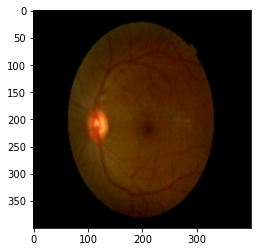

In [24]:
orj_img = img_list[4].copy()
plt.imshow(orj_img);

shape:  (358, 269, 3)


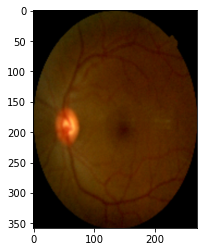

In [25]:
crop_img = orj_img[y1:y2, x1:x2]
plt.imshow(crop_img);
print("shape: ",crop_img.shape)

shape:  (400, 400, 3)


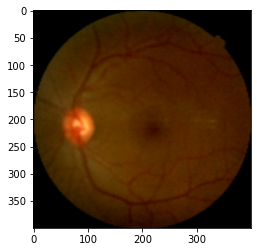

In [26]:
crop_img = cv2.resize(crop_img, (400,400))
plt.imshow(crop_img);
print("shape: ",crop_img.shape)

### Cropping the images to destroy black areas

In [27]:
x = int(x2-x1)*4//100
y = int(y2-y1)*5//100

print(x,y)

10 17


shape:  (324, 249, 3)


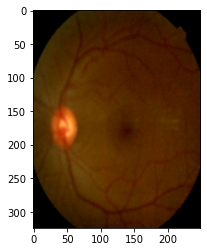

In [28]:
crop_img = orj_img[y1+y:y2-y, x1+x:x2-x]
plt.imshow(crop_img);
print("shape: ",crop_img.shape)

shape:  (400, 400, 3)


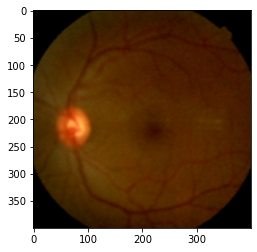

In [29]:
crop_img = cv2.resize(crop_img, (400,400))
plt.imshow(crop_img);
print("shape: ",crop_img.shape)

## CLAHE - Contrast Limited Adaptive Histogram Equalization 
* cv2.COLOR_RGB2LAB
  * LAB 
  * L => Lightness
  * A => Green - Red
  * B => Blue - Yellow 
 

In [30]:
lab = cv2.cvtColor(crop_img, cv2.COLOR_RGB2LAB)
lab.shape

(400, 400, 3)

In [31]:
l, a, b = cv2.split(lab)

shape:  (400, 400)


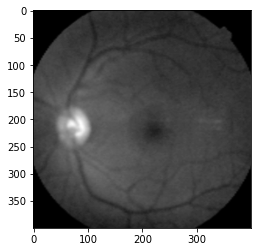

In [32]:
plt.imshow(l, cmap="gray");
print("shape: ", l.shape) # 2D

## Flatten for Histogram

In [33]:
flatten = l.flatten()

flatten.shape

(160000,)

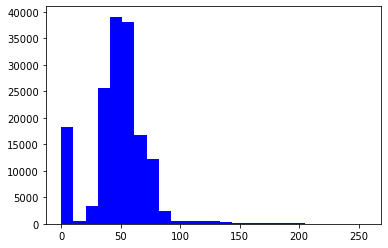

In [34]:
plt.hist(flatten, 25, [0,256], color="b")
plt.show()

In [35]:
clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=((8,8)))
cl = clahe.apply(l)

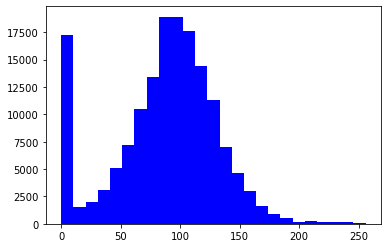

In [36]:
plt.hist(cl.flatten(), 25, [0,256], color="b")
plt.show()

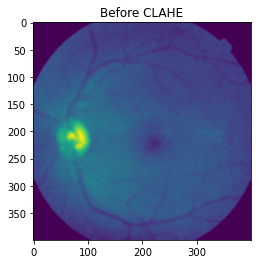

In [37]:
plt.title("Before CLAHE")
plt.imshow(l);

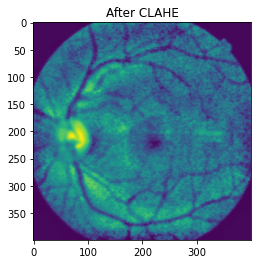

In [38]:
plt.title("After CLAHE")
plt.imshow(cl);

# Merge other channels

In [39]:
merge = cv2.merge((cl, a, b))

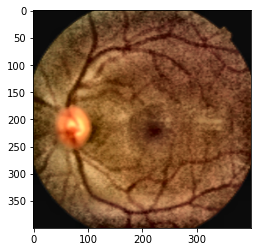

In [40]:
final_img = cv2.cvtColor(merge, cv2.COLOR_LAB2RGB)
plt.imshow(final_img);

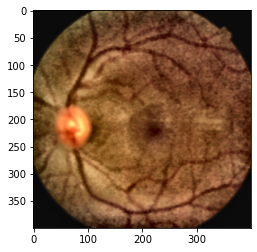

In [41]:
#Median blur ot avoid noise

med_blur = cv2.medianBlur(final_img, ksize=3)
plt.imshow(med_blur);

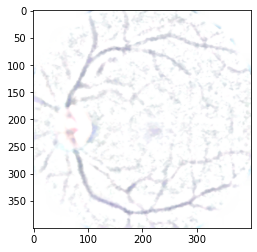

In [42]:
# Mask for bleeding vein

back_ground = cv2.medianBlur(final_img, ksize=35)
mask = cv2.addWeighted(med_blur, 1, back_ground, -1, 255)
plt.imshow(mask);

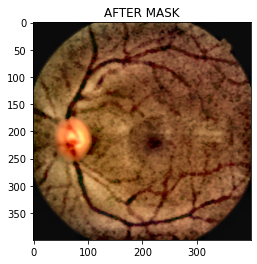

In [43]:
# Applying mask to image

final_mask = cv2.bitwise_and(mask, med_blur)
plt.title("AFTER MASK")
plt.imshow(final_mask);

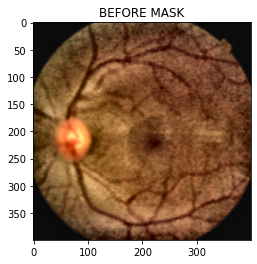

In [44]:
plt.title("BEFORE MASK")
plt.imshow(med_blur);

In [45]:
from tqdm import tqdm_notebook as tqdm

path = "C:\\Users\\prabh\\OneDrive\\Desktop\\Projects\\AI - Blindness Detection\\"
files = os.listdir(path + "train_images")

def preprocessing(files):
    """
    This function returns images prepared for training
    """
    img_list = []
    for i in tqdm(files):
        image = cv2.imread(path + 'train_images\\' + i)
        image = cv2.resize(image, (240, 240))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        copy = image.copy()
        copy = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
        blur = cv2.GaussianBlur(copy, (5, 5), 0)

        thresh = cv2.threshold(blur, 10, 255, cv2.THRESH_BINARY)[1]

        # CONTOUR DETECTION
        contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour = contour[0][0]
        contour = contour[:, 0, :]

        # GET COORDINATES
        x1 = tuple(contour[contour[:, 0].argmin()])[0]
        y1 = tuple(contour[contour[:, 1].argmin()])[1]
        x2 = tuple(contour[contour[:, 0].argmax()])[0]
        y2 = tuple(contour[contour[:, 1].argmax()])[1]

        #Crop Images Again to Destroy Black Area
        x = int(x2 - x1) * 4 // 50
        y = int(y2 - y1) * 5 // 50

        # THRES FOR CROPPED IMAGES
        copy2 = image.copy()
        if x2 - x1 > 100 and y2 - y1 > 100:
            copy2 = copy2[y1 + y: y2 - y, x1 + x: x2 - x]
            copy2 = cv2.resize(copy2, (240, 240))

        # LAB
        lab = cv2.cvtColor(copy2, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        # CLAHE - Contrast-Limited Adaptive Histogram Equalization
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=((8, 8)))
        cl = clahe.apply(l)

        # MERGING LAB
        merge = cv2.merge((cl, a, b))
        final_img = cv2.cvtColor(merge, cv2.COLOR_LAB2RGB)
        med_blur = cv2.medianBlur(final_img, 3)
        back_gorund = cv2.medianBlur(final_img, 37)

        # MASK FOR BLEEDING VEIN
        mask = cv2.addWeighted(med_blur, 1, back_gorund, -1, 255)
        final = cv2.bitwise_and(mask, med_blur)
        img_list.append(final)

    return img_list


img_list = preprocessing(files=files)

<ipython-input-45-f69701076eaf>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(files):


  0%|          | 0/3662 [00:00<?, ?it/s]

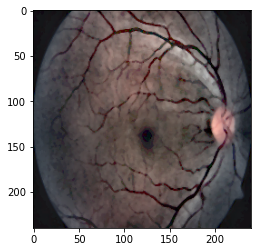

In [46]:
plt.imshow(img_list[6]);

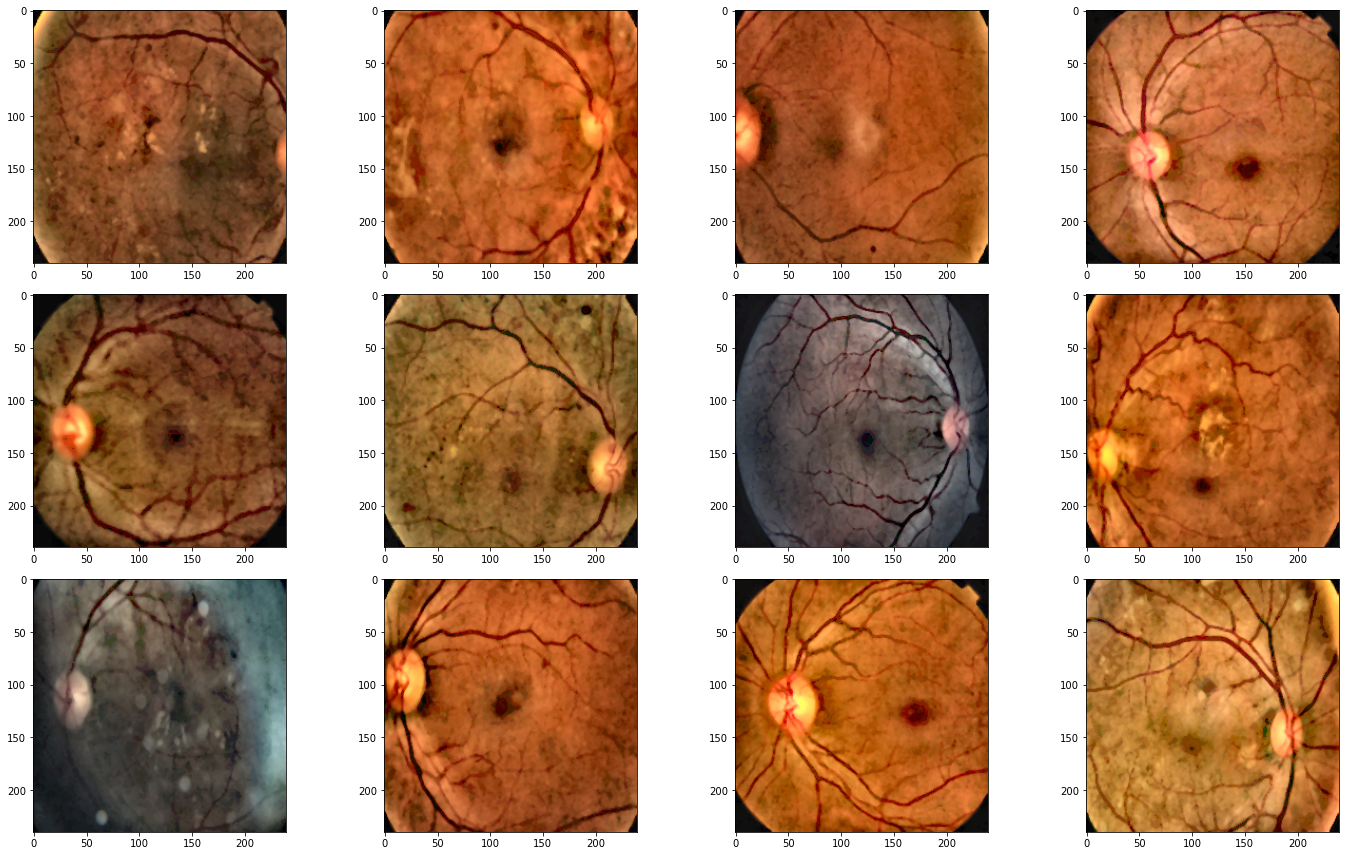

In [47]:
fig = plt.figure(figsize=(20,12))

for i in range(12):
    img = img_list[i]
    fig.add_subplot(3,4,i+1)
    plt.imshow(img)
    
plt.tight_layout()

# One Hot Encoding for DataFrame

In [48]:
df["diagnosis"]

0       2
1       4
2       1
3       0
4       0
       ..
3657    2
3658    0
3659    2
3660    0
3661    2
Name: diagnosis, Length: 3662, dtype: int64

In [49]:
y_train = pd.get_dummies(df["diagnosis"]).values
y_train

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

----

In [50]:
y_train_final = np.ones(y_train.shape, dtype='uint8')
y_train_final

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       ...,
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=uint8)

In [51]:
y_train_final[:,4] = y_train[:,4]
y_train_final

array([[1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0],
       ...,
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0]], dtype=uint8)

# Converting to Multi-Label 

In [52]:
for i in range(3,-1,-1):
    y_train_final[:,i] = np.logical_or(y_train[:,i], y_train_final[:,i+1])
    
y_train_final

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0],
       ...,
       [1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0]], dtype=uint8)

In [53]:
y_train 

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [54]:
# Converting Image to Array

x_train = np.array(img_list)
x_train.shape

(3662, 240, 240, 3)

In [55]:
y_train_final.shape

(3662, 5)

In [56]:
# Slpitting the training and testing datasets

X_train, X_val, y_train, y_val = train_test_split(x_train, y_train_final, test_size=0.2, random_state=42, shuffle=True)

In [57]:
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

X_train: (2929, 240, 240, 3)
X_val: (733, 240, 240, 3)
y_train: (2929, 5)
y_val: (733, 5)


In [58]:
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True, zoom_range=0.3, width_shift_range=0.2, height_shift_range=0.2, fill_mode='constant', cval=0.1)
batch_size = 2
data_generator = datagen.flow(X_train,y_train,batch_size=batch_size,seed=42)

# Transfer Learning

In [59]:
model = Sequential()
model.add(EfficientNetB5(include_top=False, input_shape=(240,240,3)))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(5, activation="sigmoid"))

In [60]:
model.compile(loss='binary_crossentropy',
               optimizer=Adam(lr=0.00005),
               metrics=['accuracy'])

C:\Users\prabh\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
